In [8]:
# import geopandas and matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from shapely.geometry import Polygon, Point
import warnings
warnings.filterwarnings('ignore')

# Preprocessing

## Preparing Basemaps

In [9]:
#load dataframe
path = "Data/NYPD_data/Precincts_geo/nypp.shp"

# open shapefile
pcints = gpd.read_file(path).to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['Precinct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = gpd.GeoDataFrame()
clean_map['Precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.Precinct]

In [10]:
clean_map

,Precinct,geometry
0,1,"POLYGON ((-73.99761 40.72580, -73.99677 40.725..."
1,5,"POLYGON ((-73.98864 40.72293, -73.98869 40.722..."
2,6,"POLYGON ((-73.99968 40.73855, -73.99684 40.737..."
3,7,"POLYGON ((-73.97345 40.71896, -73.97351 40.718..."
4,9,"POLYGON ((-73.97161 40.72672, -73.97163 40.726..."
...,...,...
72,115,"POLYGON ((-73.85908 40.76252, -73.85943 40.762..."
73,120,"POLYGON ((-74.05357 40.60370, -74.05407 40.603..."
74,121,"POLYGON ((-74.17988 40.64511, -74.17984 40.645..."
75,122,"POLYGON ((-74.10723 40.61025, -74.10668 40.610..."


## Data

In [51]:
#upload pre covid dataframe 
pre_data = pd.read_csv('Data/EDA_data/pre_covid_crime.csv')
pre_data.rename(columns={'ARREST_PRECINCT':'Precinct'}, inplace = True)
pre_data.head()

,ARREST_DATE,WeekDay,Month,Crime Severity,ARREST_BORO,Precinct,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column
0,2019-03-01,4,3,Mild,Manhatten,14,25-44,M,BLACK,40.757578,-73.989545,POINT (-73.98954452399994 40.75757811200003)
1,2019-03-01,4,3,Minor,Queens,109,18-24,M,WHITE,40.781417,-73.778168,POINT (-73.77816787699999 40.78141724100004)
2,2019-03-01,4,3,Minor,Brooklyn,60,18-24,M,BLACK,40.575574,-73.981204,POINT (-73.98120362499998 40.575573630000065)
3,2019-03-01,4,3,Mild,Brooklyn,79,18-24,M,BLACK,40.688378,-73.944912,POINT (-73.94491165999996 40.68837827800007)
4,2019-03-01,4,3,Minor,Bronx,41,45-64,M,WHITE HISPANIC,40.814684,-73.891918,POINT (-73.89191764199995 40.81468425600008)


In [52]:
#Count number of arrests for each precinct in pre covid period
pre_data = pre_data.groupby('Precinct')['ARREST_DATE'].count()

pre_data = pd.DataFrame(pre_data) #turn back into dataframe
pre_data.reset_index(inplace=True) #reset index
pre_data.rename(columns={'ARREST_DATE':'Number of Arrests'}, inplace = True)

#view dataframe
pre_data.head()

,Precinct,Number of Arrests
0,1,2248
1,5,3160
2,6,2069
3,7,1796
4,9,1744


In [53]:
pre_covid = pd.merge(clean_map, pre_data, on = 'Precinct')
pre_covid

,Precinct,geometry,Number of Arrests
0,1,"POLYGON ((-73.99761 40.72580, -73.99677 40.725...",2248
1,5,"POLYGON ((-73.98864 40.72293, -73.98869 40.722...",3160
2,6,"POLYGON ((-73.99968 40.73855, -73.99684 40.737...",2069
3,7,"POLYGON ((-73.97345 40.71896, -73.97351 40.718...",1796
4,9,"POLYGON ((-73.97161 40.72672, -73.97163 40.726...",1744
...,...,...,...
72,115,"POLYGON ((-73.85908 40.76252, -73.85943 40.762...",3565
73,120,"POLYGON ((-74.05357 40.60370, -74.05407 40.603...",3169
74,121,"POLYGON ((-74.17988 40.64511, -74.17984 40.645...",2337
75,122,"POLYGON ((-74.10723 40.61025, -74.10668 40.610...",1637


In [55]:
#upload covid dataframe 
cov_data = pd.read_csv('Data/EDA_data/covid_crime.csv')
cov_data.rename(columns={'ARREST_PRECINCT':'Precinct'}, inplace = True)
cov_data.head()

,ARREST_DATE,WeekDay,Month,Crime Severity,ARREST_BORO,Precinct,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column
0,2020-03-01,6,3,Severe,Brooklyn,70,18-24,M,BLACK,40.647951,-73.960606,POINT (-73.96060645599994 40.64795139700004)
1,2020-03-01,6,3,Minor,Staten Island,120,45-64,M,WHITE HISPANIC,40.645023,-74.077217,POINT (-74.077216847 40.645022746000045)
2,2020-03-01,6,3,Severe,Bronx,42,25-44,M,BLACK,40.829510,-73.888056,POINT (-73.88805604799995 40.829510293000055)
3,2020-03-01,6,3,Severe,Brooklyn,73,45-64,F,BLACK,40.672574,-73.910176,POINT (-73.91017639799998 40.67257395100007)
4,2020-03-01,6,3,Minor,Queens,113,25-44,M,BLACK,40.677514,-73.789838,POINT (-73.78983757299993 40.67751412800004)


In [56]:
#Count number of arrests for each precinct in pre covid period
cov_data = cov_data.groupby('Precinct')['ARREST_DATE'].count()

cov_data = pd.DataFrame(cov_data) #turn back into dataframe
cov_data.reset_index(inplace=True) #reset index
cov_data.rename(columns={'ARREST_DATE':'Number of Arrests'}, inplace = True)

#view dataframe
cov_data.head()

,Precinct,Number of Arrests
0,1,1125
1,5,1476
2,6,1488
3,7,1138
4,9,1120


In [57]:
covid = pd.merge(clean_map, cov_data, on = 'Precinct')
covid

,Precinct,geometry,Number of Arrests
0,1,"POLYGON ((-73.99761 40.72580, -73.99677 40.725...",1125
1,5,"POLYGON ((-73.98864 40.72293, -73.98869 40.722...",1476
2,6,"POLYGON ((-73.99968 40.73855, -73.99684 40.737...",1488
3,7,"POLYGON ((-73.97345 40.71896, -73.97351 40.718...",1138
4,9,"POLYGON ((-73.97161 40.72672, -73.97163 40.726...",1120
...,...,...,...
72,115,"POLYGON ((-73.85908 40.76252, -73.85943 40.762...",2206
73,120,"POLYGON ((-74.05357 40.60370, -74.05407 40.603...",2075
74,121,"POLYGON ((-74.17988 40.64511, -74.17984 40.645...",1702
75,122,"POLYGON ((-74.10723 40.61025, -74.10668 40.610...",1116


# Create Basic Maps

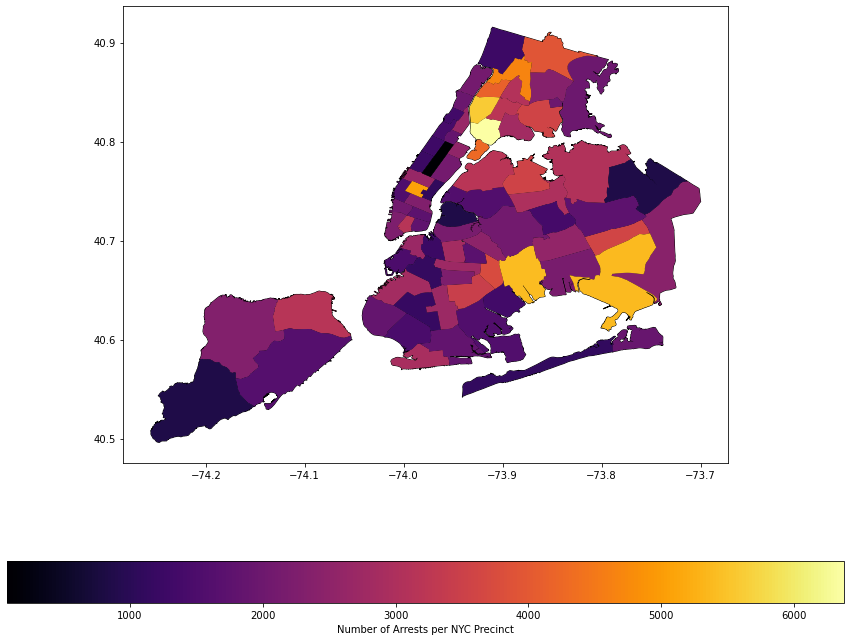

In [77]:
# create figure and axes
fig, ax = plt.subplots(figsize = (15,12))


# create map from world_filtered data-frame
base = clean_map.plot(ax=ax, color='white', edgecolor='black')
pre_covid.plot(column = "Number of Arrests", ax =base, legend = True,cmap = 'inferno',
                   legend_kwds = {'label': 'Number of Arrests per NYC Precinct',
                                 'orientation':'horizontal'})


plt.show()

#save plot
fig= ax.get_figure()
fig.savefig('Figures/Map Pre-Covid.png')

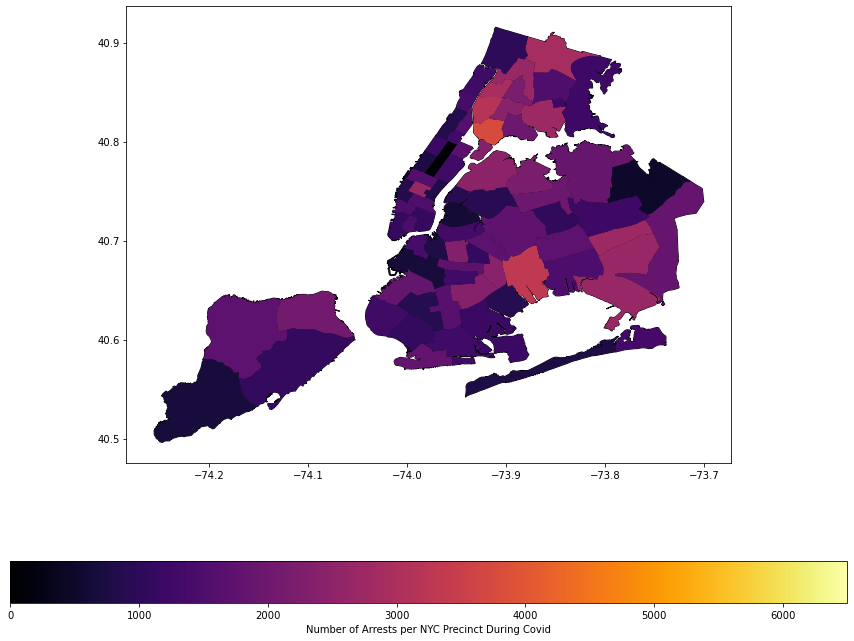

In [78]:
# create figure and axes
fig, ax = plt.subplots(figsize = (15,12))


# create map from world_filtered data-frame
base = clean_map.plot(ax=ax, color='white', edgecolor='black')
covid.plot(column = "Number of Arrests", ax =base, legend = True, cmap = 'inferno',
           vmin = 0, vmax = 6500, 
           legend_kwds = {'label': 'Number of Arrests per NYC Precinct During Covid',
                                 'orientation':'horizontal'})


plt.show()

#save plot
fig= ax.get_figure()
fig.savefig('Figures/Map Covid.png')

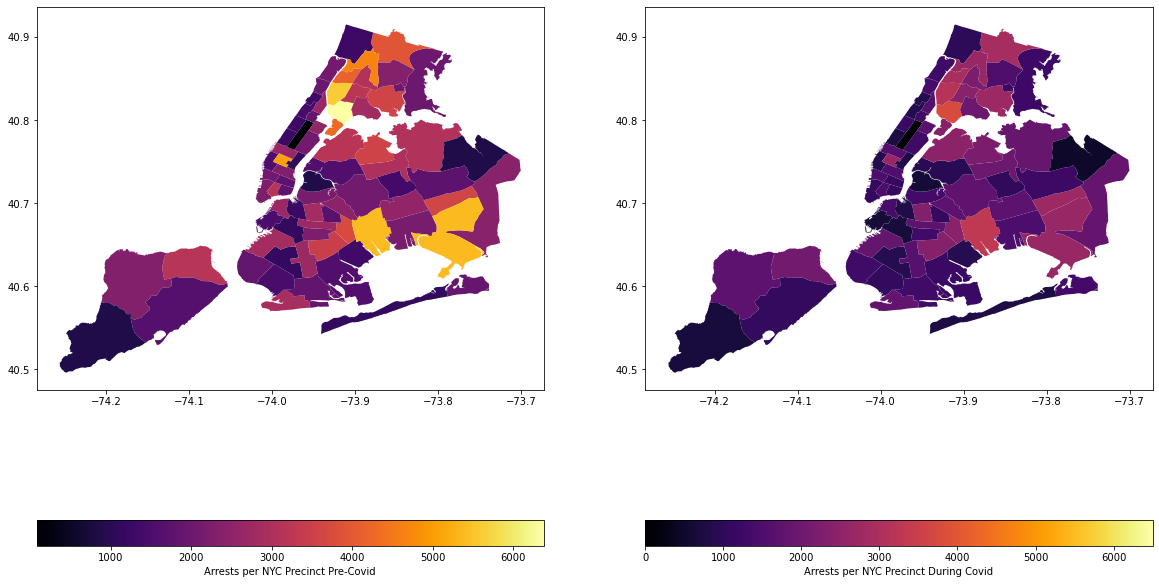

In [82]:
# create figure and axes
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16))

# create map from world_filtered data-frame
base = clean_map.plot(ax=ax, color='white', edgecolor='black')
ax1 = pre_covid.plot(ax=ax1, column='Number of Arrests',cmap = 'inferno', legend = True,
                     legend_kwds = {'label': 'Arrests per NYC Precinct Pre-Covid',
                                 'orientation':'horizontal'})
ax2 = covid.plot(ax =ax2, column = "Number of Arrests", cmap = 'inferno', legend = True,
           vmin = 0, vmax = 6500, 
                legend_kwds = {'label': 'Arrests per NYC Precinct During Covid',
                                 'orientation':'horizontal'})

plt.show()
